<h1 style="background-color:#C2B4B9;color:white;text-align: center;padding-top: 5px;padding-bottom: 5px;border-radius: 5px 5px;"><strong><centre>Motion Activity Classification Using Recurrent Neural Networks </centre></strong></h1>

<h2 style="background-color:#C2B4B9;color:white;text-align: center;padding-top: 5px;padding-bottom: 5px;border-radius: 5px 5px;"><strong><centre>Methodology: Model Architecture </centre></strong></h2>

#### 03.Model Development
**Objective:** Train a Tradicional RNN model on the preprocessed dataset.

**Model Training:** <br>
<br>
 - **Base Model:**
    + Defines the RNN architecture;
    + Compiles the model with the Adam optimizer and categorical cross-entropy loss;
    + Test adding mores layers to see if the performance gets better
 
 - **Training and Evaluation:**
    + Utilizes EarlyStopping and ModelCheckpoint callbacks for efficient training.
    + Trains the model and evaluates its performance on the validation set.
    + Includes code to visualize training and validation accuracy over epochs.

---

## **Carregamento das Bibliotecas Base**

In [43]:
import os 
import pandas as pd
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import SimpleRNN, Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential

import time
import pickle

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

## **Carregamento e Leitura do *Dataset* Pré-processado**

In [44]:
# Definir o caminho do arquivo relativo ao diretório do script
#file_path = os.path.join(os.getcwd(), 'RNN_dataset', 'concatDataset.csv')

base_dir = r'C:\\Users\\maria\\OneDrive - Instituto Superior de Engenharia do Porto\\Desktop\\Semestre\\APROF\\mei-approf\\RNN\\datasets'
file_name = 'preprocessDataset.csv'

file_path = os.path.join(base_dir, file_name)
print(file_path)

C:\\Users\\maria\\OneDrive - Instituto Superior de Engenharia do Porto\\Desktop\\Semestre\\APROF\\mei-approf\\RNN\\datasets\preprocessDataset.csv


+ Utilização do método `read_csv()` para leitura do arquivo CSV com os dados pré-processados

In [45]:
df_motionSense = pd.read_csv(file_path)

+ Visualização das 5 primeiras linhas do *dataset* utilizando o método `head()`

In [46]:
df_motionSense.head(5)

,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z,category_encoded
0,0.972412,1.112051,0.372160,2.329043,-0.814143,0.190001,0.163109,0.417746,0.891213,0.591696,-0.307112,0.677785,0
1,0.972325,1.157371,0.361670,2.365755,-0.865384,0.187932,0.443882,0.221714,0.524710,0.436217,-0.038492,0.186239,0
2,0.972184,1.184141,0.357830,2.387092,-0.896006,0.186328,-0.080028,-0.036082,0.274351,0.006391,0.082024,-0.342729,0
3,0.965350,1.190361,0.360527,2.390690,-0.903162,0.156397,-0.019555,-0.594680,0.017573,-0.032954,0.084569,0.148985,0
4,0.951164,1.192398,0.358982,2.388570,-0.905503,0.094676,0.054879,-0.519408,0.027154,0.395098,0.349372,-0.111607,0


## **Definição de Variáveis Fixas**

In [47]:
NUM_FEATURES = df_motionSense.shape[1] - 1
NUM_CLASSES = df_motionSense['category_encoded'].nunique()
EPOCHS = 50

**Sequencing Data for Temporal Analysis**

We define a sequence generator function that creates sequences of input features and corresponding target labels from the training and testing data. These sequences have a window length of 150 with a stride of 10. The mode of target labels within each sequence is calculated to represent the label for that sequence. This prepares the data for temporal analysis tasks.

## **Preparação do *Dataset***

+ A função `prepare_data()` realiza o pré-processamento necessário para treinar um modelo de classificação de atividades baseado em RNNs. Este cria sequências de dados a partir da função `create_sequence()` e divide o conjunto de dados em treino e teste.

Esta divisão foi feita com base na função `train_test_split()` do scikit-learn que permite dividir o conjunto de dados em conjuntos de treino e teste. Este separa as *features* ('x_columns') e a *target* ('y_columns') com um tamanho de conjunto de teste de, neste caso, 20% (`test_size=0.2`), garantindo que os comprimentos dos conjuntos de treino para *features* e *targets* sejam os mesmos.

In [48]:
def prepare_data(df, window_length):
    """
    Preprocesses the dataset for training an RNN-based activity classification model.

    Args:
        df (pandas.DataFrame): The input dataset containing features and labels.
        window_length (int): The desired length of the time window for creating sequences.

    Returns:
        X_train, X_test, y_train, y_test: Processed training and testing data.
    """
    def create_sequences(data, target, window_size):
        sequences = []
        targets = []
        for i in range(len(data) - window_size):
            seq = data[i:i+window_size]
            label = target[i+window_size]
            sequences.append(seq)
            targets.append(label)
        return np.array(sequences), np.array(targets)
    
    y = df['category_encoded']
    X = df.drop(columns=['category_encoded'])
    
    X_seq, y_seq = create_sequences(X, y, window_length)
    
    X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)
    
    y_train = to_categorical(y_train, num_classes=y.nunique())
    y_test = to_categorical(y_test, num_classes=y.nunique())
    
    return X_train, X_test, y_train, y_test

## **Definição de Métodos de Regularização**

Os callbacks `EarlyStopping` e `ReduceLROnPlateau` são ferramentas essenciais para otimizar o treino de modelos de Deep Learning no TensorFlow Keras.

+ O `EarlyStopping` interrompe o treino quando uma métrica específica, como a perda de validação (`val_loss`), não mostra melhorias por um número definido de épocas (`patience=10`);    , prevenindo o sobreajuste.

+ O `ReduceLROnPlateau` ajusta dinamicamente a taxa de aprendizagem (`factor=0.2`) do otimizador se a métrica monitorizada (`val_loss`) não apresentar melhorias após um número específico de épocas (`patience=5`), permitindo uma convergência mais suave do modelo.

Usados em conjunto, estes callbacks melhoram a eficiência e a qualidade do treino, bem como ajudam a alcançar um equilíbrio entre o desempenho do modelo e a eficiência computacional.

In [49]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

## **Definição da Função de Visualização da Avaliação**

In [50]:
def plot_training_results(history):
    
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    epochs = range(len(acc))

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label="Training Accuracy")
    plt.plot(epochs, val_acc, label="Validation Accuracy")
    plt.legend(loc="lower right")
    plt.title("Training and Validation Accuracy")

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label="Training Loss")
    plt.plot(epochs, val_loss, label="Validation Loss")
    plt.legend(loc="lower right")
    plt.title("Training and Validation Loss")

    plt.tight_layout()
    plt.show()

## **Definição das Arquiteturas com camadas RNN Tradicionais - Single Layer**

<h2 style="background-color:#C2B4B9; color:white; text-align:center; padding-top:5px; padding-bottom:5px; border-radius: 5px 5px;"><strong><centre>Modelo 1 </centre></strong></h2>

### **Janela Temporal = 20**

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_19 (SimpleRNN)       │ (None, 64)             │         4,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,283 (36.26 KB)

 Trainable params: 9,283 (36.26 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 31s 3ms/step - accuracy: 0.8013 - loss: 0.4882 - val_accuracy: 0.9072 - val_loss: 0.2733 - learning_rate: 0.0010
Epoch 2/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - accuracy: 0.9256 - loss: 0.2303 - val_accuracy: 0.9300 - val_loss: 0.2246 - learning_rate: 0.0010
Epoch 3/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - accuracy: 0.9403 - loss: 0.1888 - val_accuracy: 0.9414 - val_loss: 0.1809 - learning_rate: 0.0010
Epoch 4/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 25s 2ms/step - accuracy: 0.9458 - loss: 0.1732 - val_accuracy: 0.9513 - val_loss: 0.1610 - learning_rate: 0.0010
Epoch 5/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step - accuracy: 0.9482 - loss: 0.1643 - val_accuracy: 0.9443 - val_loss: 0.1739 - learning_rate: 0.0010
Epoch 6/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - accuracy: 0.9494 - loss: 0.1614 - val_accuracy: 0.9509 - val_loss: 0.1583 - learning_rate: 0.0010
Epoch 7/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 25s 2ms/step -

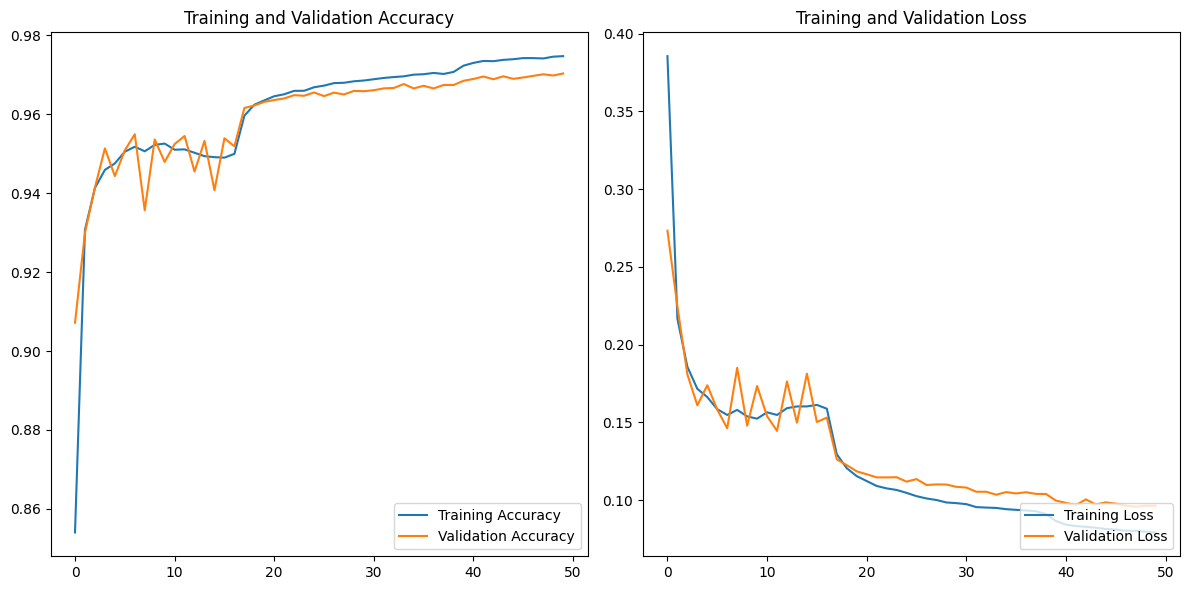

In [51]:
WINDOW_LENGTH = 20
    
X_train, X_test, y_train, y_test = prepare_data(df_motionSense, WINDOW_LENGTH)


model_1 = Sequential([
    SimpleRNN(64, activation='tanh', input_shape=(WINDOW_LENGTH, NUM_FEATURES)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(NUM_CLASSES, activation='softmax')
])


model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_1.summary()

model_1.save('../models/model_1/model_1_h1.keras')


start_time = time.time()

history_1 = model_1.fit(X_train, y_train, epochs=EPOCHS, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping, reduce_lr])

end_time = time.time()
execution_time = end_time - start_time
print(f"Tempo de execução: {execution_time} segundos")


history_path = '../models/model_1/history_1.pkl'
with open(history_path, 'wb') as file:
    pickle.dump(history_1.history, file)

loss, accuracy = model_1.evaluate(X_test, y_test)
print(f'Test loss: {loss}, Test accuracy: {accuracy}')

plot_training_results(history_1)

---

### **Janela Temporal = 30**

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_20 (SimpleRNN)       │ (None, 64)             │         4,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_14 (Flatten)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,283 (36.26 KB)

 Trainable params: 9,283 (36.26 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - accuracy: 0.7705 - loss: 0.5399 - val_accuracy: 0.9220 - val_loss: 0.2421 - learning_rate: 0.0010
Epoch 2/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step - accuracy: 0.9201 - loss: 0.2510 - val_accuracy: 0.9351 - val_loss: 0.2126 - learning_rate: 0.0010
Epoch 3/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step - accuracy: 0.9221 - loss: 0.2394 - val_accuracy: 0.9301 - val_loss: 0.2260 - learning_rate: 0.0010
Epoch 4/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 25s 2ms/step - accuracy: 0.9308 - loss: 0.2209 - val_accuracy: 0.9391 - val_loss: 0.2033 - learning_rate: 0.0010
Epoch 5/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step - accuracy: 0.9264 - loss: 0.2293 - val_accuracy: 0.9268 - val_loss: 0.2261 - learning_rate: 0.0010
Epoch 6/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step - accuracy: 0.9208 - loss: 0.2437 - val_accuracy: 0.9190 - val_loss: 0.2527 - learning_rate: 0.0010
Epoch 7/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step -

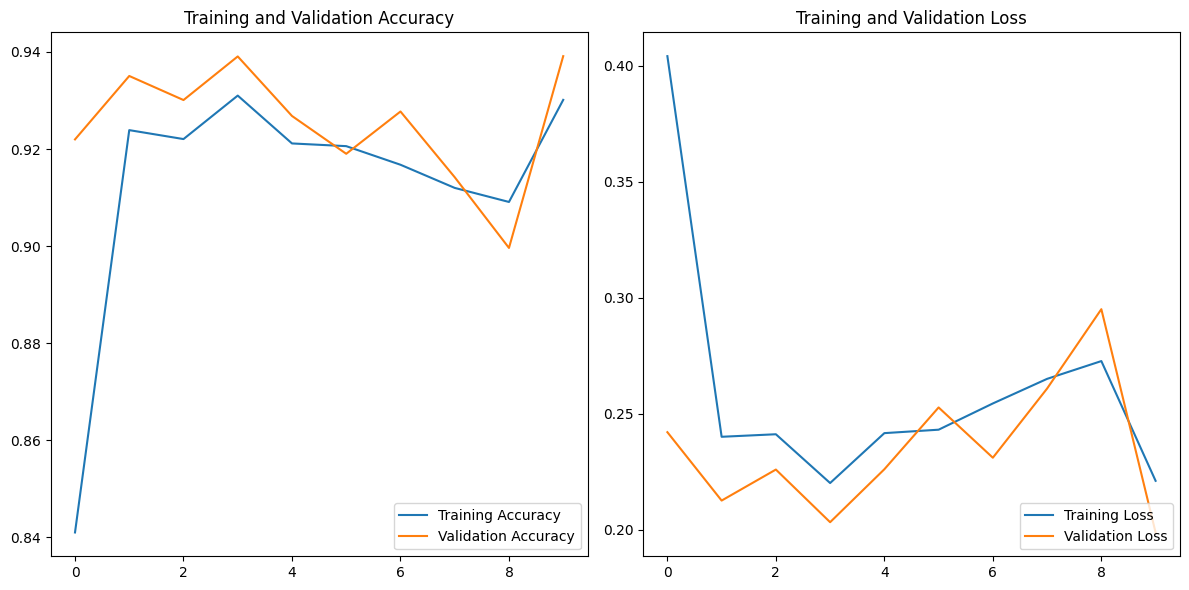

In [52]:
WINDOW_LENGTH = 30
    
X_train, X_test, y_train, y_test = prepare_data(df_motionSense, WINDOW_LENGTH)


model_1 = Sequential([
    SimpleRNN(64, activation='tanh', input_shape=(WINDOW_LENGTH, NUM_FEATURES)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(NUM_CLASSES, activation='softmax')
])


model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_1.summary()

model_1.save('../models/model_1/model_1_h2.keras')


start_time = time.time()

history_2 = model_1.fit(X_train, y_train, epochs=EPOCHS, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping, reduce_lr])

end_time = time.time()
execution_time = end_time - start_time
print(f"Tempo de execução: {execution_time} segundos")


history_path = '../models/model_1/history_2.pkl'
with open(history_path, 'wb') as file:
    pickle.dump(history_2.history, file)


loss, accuracy = model_1.evaluate(X_test, y_test)
print(f'Test loss: {loss}, Test accuracy: {accuracy}')

plot_training_results(history_2)  

---

### **Janela Temporal = 50**

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_21 (SimpleRNN)       │ (None, 64)             │         4,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_15 (Flatten)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,283 (36.26 KB)

 Trainable params: 9,283 (36.26 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - accuracy: 0.7339 - loss: 0.6113 - val_accuracy: 0.8114 - val_loss: 0.4563 - learning_rate: 0.0010
Epoch 2/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 38s 4ms/step - accuracy: 0.7777 - loss: 0.5238 - val_accuracy: 0.8782 - val_loss: 0.3591 - learning_rate: 0.0010
Epoch 3/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 37s 3ms/step - accuracy: 0.7215 - loss: 0.6360 - val_accuracy: 0.7905 - val_loss: 0.5038 - learning_rate: 0.0010
Epoch 4/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - accuracy: 0.7612 - loss: 0.5526 - val_accuracy: 0.7363 - val_loss: 0.6055 - learning_rate: 0.0010
Epoch 5/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 36s 3ms/step - accuracy: 0.7079 - loss: 0.6490 - val_accuracy: 0.8002 - val_loss: 0.4826 - learning_rate: 0.0010
Epoch 6/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 35s 3ms/step - accuracy: 0.7917 - loss: 0.4970 - val_accuracy: 0.7757 - val_loss: 0.5379 - learning_rate: 0.0010
Epoch 7/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 35s 3ms/step -

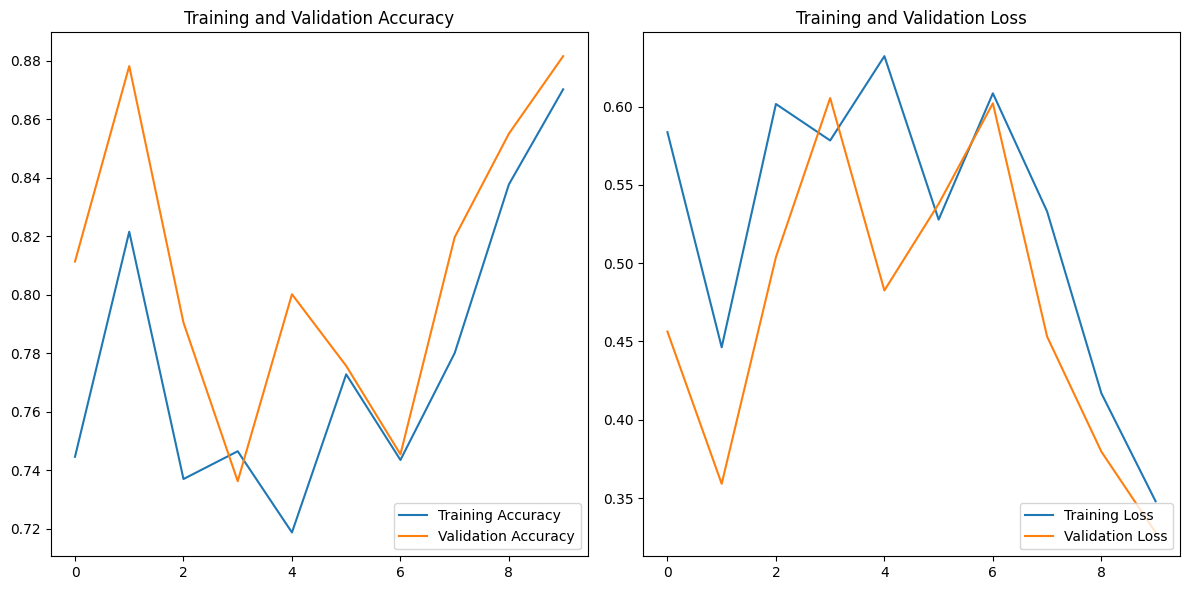

In [53]:
WINDOW_LENGTH = 50
    
X_train, X_test, y_train, y_test = prepare_data(df_motionSense, WINDOW_LENGTH)


model_1 = Sequential([
    SimpleRNN(64, activation='tanh', input_shape=(WINDOW_LENGTH, NUM_FEATURES)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(NUM_CLASSES, activation='softmax')
])


model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_1.summary()

model_1.save('../models/model_1/model_1_h3.keras')


start_time = time.time()

history_3 = model_1.fit(X_train, y_train, epochs=EPOCHS, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping, reduce_lr])

end_time = time.time()
execution_time = end_time - start_time
print(f"Tempo de execução: {execution_time} segundos")


history_path = '../models/model_1/history_3.pkl'
with open(history_path, 'wb') as file:
    pickle.dump(history_3.history, file)


loss, accuracy = model_1.evaluate(X_test, y_test)
print(f'Test loss: {loss}, Test accuracy: {accuracy}')

plot_training_results(history_3)  

<h2 style="background-color:#C2B4B9; color:white; text-align:center; padding-top:5px; padding-bottom:5px; border-radius: 5px 5px;"><strong><centre>Modelo 2 </centre></strong></h2>

### **Janela Temporal = 20**

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_22 (SimpleRNN)       │ (None, 128)            │        18,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_16 (Flatten)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,459 (138.51 KB)

 Trainable params: 35,203 (137.51 KB)

 Non-trainable params: 256 (1.00 KB)

Epoch 1/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 31s 3ms/step - accuracy: 0.8283 - loss: 0.4642 - val_accuracy: 0.8973 - val_loss: 0.3129 - learning_rate: 0.0010
Epoch 2/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 38s 4ms/step - accuracy: 0.9266 - loss: 0.2465 - val_accuracy: 0.9423 - val_loss: 0.1927 - learning_rate: 0.0010
Epoch 3/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - accuracy: 0.9325 - loss: 0.2295 - val_accuracy: 0.9496 - val_loss: 0.1729 - learning_rate: 0.0010
Epoch 4/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 32s 3ms/step - accuracy: 0.9374 - loss: 0.2146 - val_accuracy: 0.9495 - val_loss: 0.1658 - learning_rate: 0.0010
Epoch 5/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 32s 3ms/step - accuracy: 0.9418 - loss: 0.2033 - val_accuracy: 0.9437 - val_loss: 0.1825 - learning_rate: 0.0010
Epoch 6/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 32s 3ms/step - accuracy: 0.9344 - loss: 0.2211 - val_accuracy: 0.9413 - val_loss: 0.1867 - learning_rate: 0.0010
Epoch 7/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step -

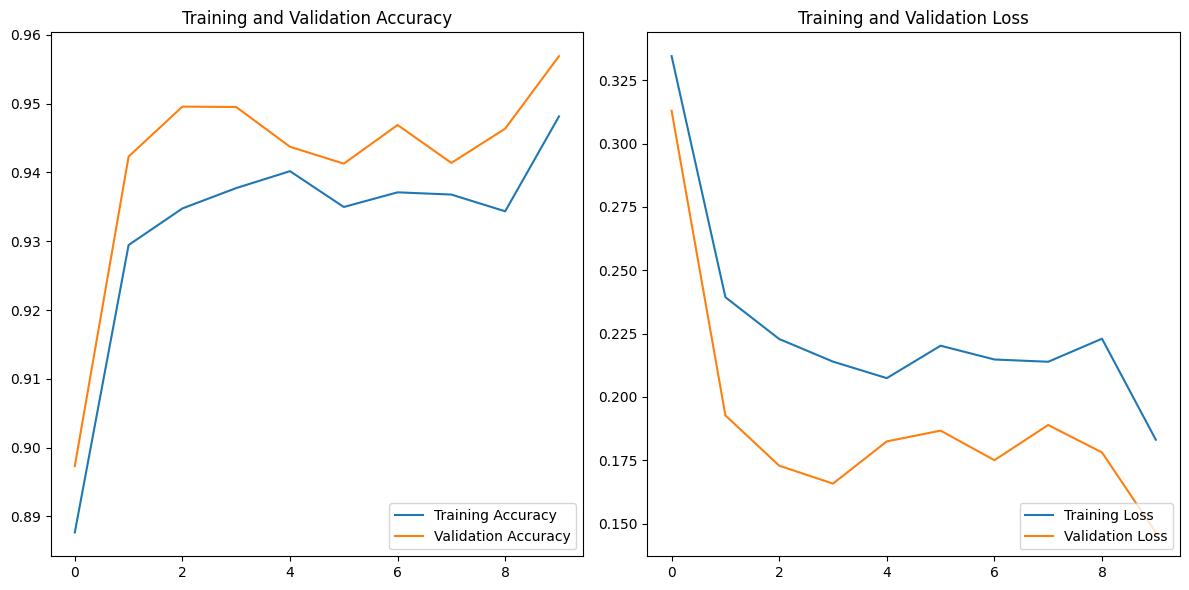

In [54]:
WINDOW_LENGTH = 20
    
X_train, X_test, y_train, y_test = prepare_data(df_motionSense, WINDOW_LENGTH)


model_2 = Sequential([
    SimpleRNN(128, activation='tanh', input_shape=(WINDOW_LENGTH, NUM_FEATURES)),
    Dropout(0.5),          
    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),  
    Dropout(0.5),          
    Dense(NUM_CLASSES, activation='softmax')
])


model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_2.summary()

model_2.save('../models/model_2/model_2_h4.keras')

start_time = time.time()

history_4 = model_2.fit(X_train, y_train, epochs=EPOCHS, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping, reduce_lr])

end_time = time.time()
execution_time = end_time - start_time
print(f"Tempo de execução: {execution_time} segundos")


history_path = '../models/model_2/history_4.pkl'
with open(history_path, 'wb') as file:
    pickle.dump(history_4.history, file)


loss, accuracy = model_2.evaluate(X_test, y_test)
print(f'Test loss: {loss}, Test accuracy: {accuracy}')

plot_training_results(history_4)  

---

### **Janela Temporal= 30**

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_26 (SimpleRNN)       │ (None, 128)            │        18,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_20 (Flatten)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,459 (138.51 KB)

 Trainable params: 35,203 (137.51 KB)

 Non-trainable params: 256 (1.00 KB)

Epoch 1/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 47s 4ms/step - accuracy: 0.7572 - loss: 0.5920 - val_accuracy: 0.8362 - val_loss: 0.4090 - learning_rate: 0.0010
Epoch 2/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - accuracy: 0.8538 - loss: 0.4070 - val_accuracy: 0.9051 - val_loss: 0.2996 - learning_rate: 0.0010
Epoch 3/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 39s 4ms/step - accuracy: 0.8992 - loss: 0.3179 - val_accuracy: 0.9232 - val_loss: 0.2620 - learning_rate: 0.0010
Epoch 4/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 39s 4ms/step - accuracy: 0.9128 - loss: 0.2890 - val_accuracy: 0.9238 - val_loss: 0.2501 - learning_rate: 0.0010
Epoch 5/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 39s 4ms/step - accuracy: 0.8914 - loss: 0.3269 - val_accuracy: 0.9171 - val_loss: 0.2555 - learning_rate: 0.0010
Epoch 6/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - accuracy: 0.8742 - loss: 0.3629 - val_accuracy: 0.8284 - val_loss: 0.4971 - learning_rate: 0.0010
Epoch 7/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step -

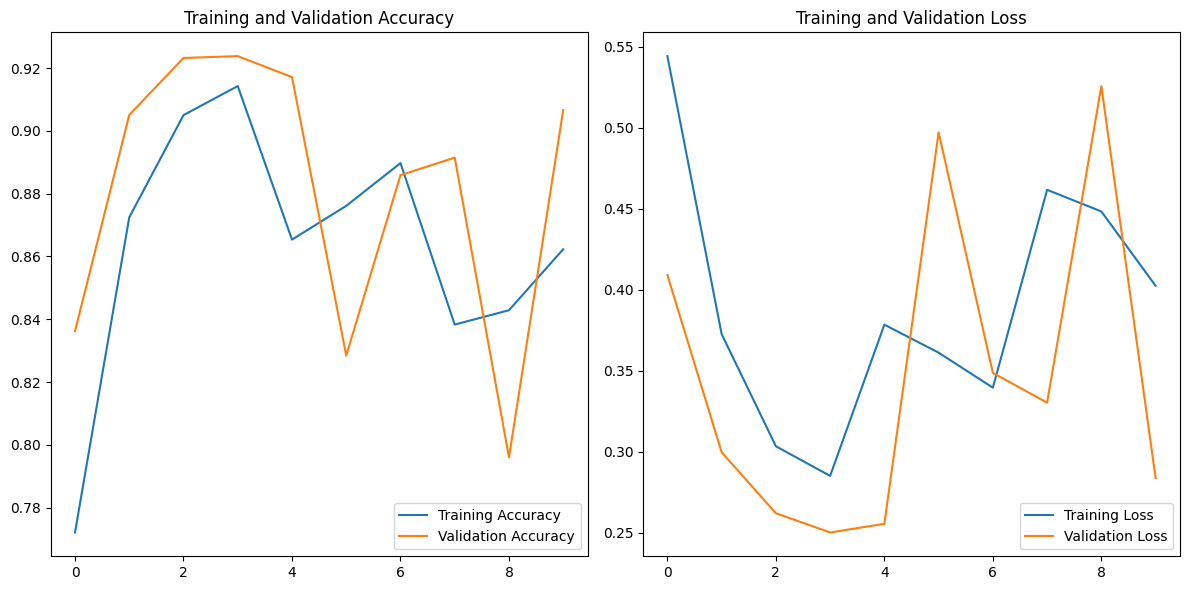

In [59]:
WINDOW_LENGTH = 30
    
X_train, X_test, y_train, y_test = prepare_data(df_motionSense, WINDOW_LENGTH)


model_2 = Sequential([
    SimpleRNN(128, activation='tanh', input_shape=(WINDOW_LENGTH, NUM_FEATURES)),
    Dropout(0.5),          
    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),  
    Dropout(0.5),          
    Dense(NUM_CLASSES, activation='softmax')
])


model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_2.summary()

model_2.save('../models/model_2/model_2_h5.keras')

start_time = time.time()

history_5 = model_2.fit(X_train, y_train, epochs=EPOCHS, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping, reduce_lr])

end_time = time.time()
execution_time = end_time - start_time
print(f"Tempo de execução: {execution_time} segundos")


history_path = '../models/model_2/history_5.pkl'
with open(history_path, 'wb') as file:
    pickle.dump(history_5.history, file)


loss, accuracy = model_2.evaluate(X_test, y_test)
print(f'Test loss: {loss}, Test accuracy: {accuracy}')

plot_training_results(history_5)  

---

### **Janela Temporal = 50**

Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_35 (SimpleRNN)       │ (None, 128)            │        18,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_28 (Flatten)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,459 (138.51 KB)

 Trainable params: 35,203 (137.51 KB)

 Non-trainable params: 256 (1.00 KB)

Epoch 1/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 93s 9ms/step - accuracy: 0.5548 - loss: 0.9405 - val_accuracy: 0.8321 - val_loss: 0.3929 - learning_rate: 0.0010
Epoch 2/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 120s 11ms/step - accuracy: 0.8092 - loss: 0.4751 - val_accuracy: 0.9261 - val_loss: 0.2352 - learning_rate: 0.0010
Epoch 3/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 58s 5ms/step - accuracy: 0.9001 - loss: 0.2971 - val_accuracy: 0.8525 - val_loss: 0.3908 - learning_rate: 0.0010
Epoch 4/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 58s 5ms/step - accuracy: 0.8409 - loss: 0.4185 - val_accuracy: 0.7421 - val_loss: 0.5518 - learning_rate: 0.0010
Epoch 5/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 149s 14ms/step - accuracy: 0.8145 - loss: 0.4576 - val_accuracy: 0.7522 - val_loss: 0.5387 - learning_rate: 0.0010
Epoch 6/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 63s 6ms/step - accuracy: 0.7848 - loss: 0.5113 - val_accuracy: 0.8500 - val_loss: 0.3750 - learning_rate: 0.0010
Epoch 7/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 60s 6ms/st

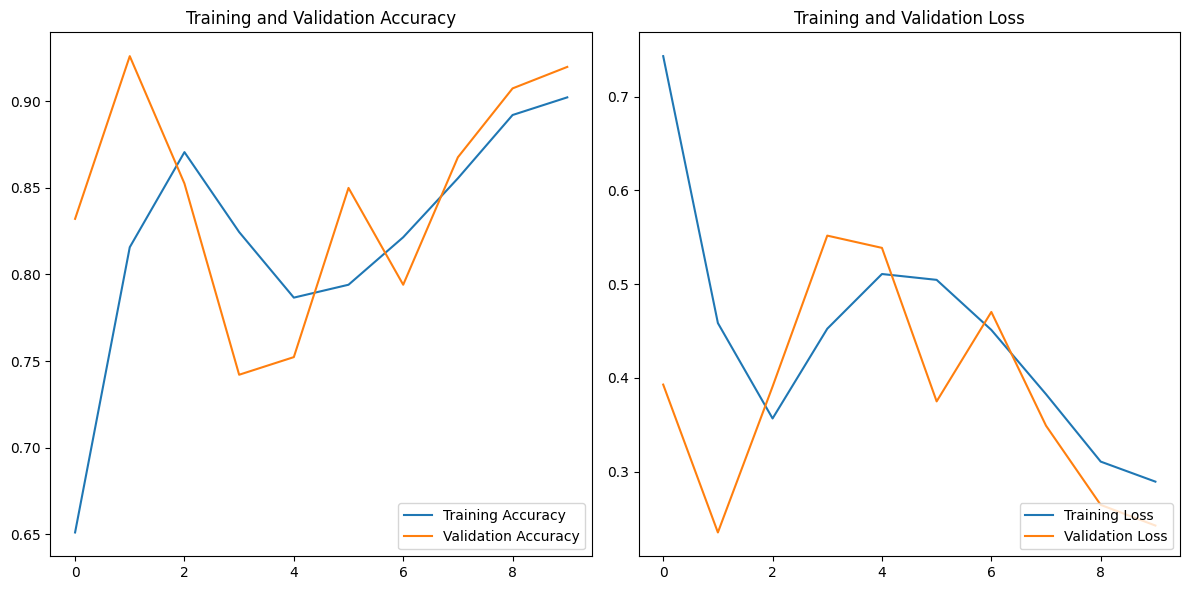

In [87]:
WINDOW_LENGTH = 50
    
X_train, X_test, y_train, y_test = prepare_data(df_motionSense, WINDOW_LENGTH)


model_2 = Sequential([
    SimpleRNN(128, activation='tanh', input_shape=(WINDOW_LENGTH, NUM_FEATURES)),
    Dropout(0.5),          
    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),  
    Dropout(0.5),          
    Dense(NUM_CLASSES, activation='softmax')
])


model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_2.summary()

model_2.save('../models/model_2/model_2_h6.keras')

start_time = time.time()

history_6 = model_2.fit(X_train, y_train, epochs=EPOCHS, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping, reduce_lr])

end_time = time.time()
execution_time = end_time - start_time
print(f"Tempo de execução: {execution_time} segundos")


history_path = '../models/model_2/history_6.pkl'
with open(history_path, 'wb') as file:
    pickle.dump(history_6.history, file)


loss, accuracy = model_2.evaluate(X_test, y_test)
print(f'Test loss: {loss}, Test accuracy: {accuracy}')

plot_training_results(history_6)  

<h2 style="background-color:#C2B4B9; color:white; text-align:center; padding-top:5px; padding-bottom:5px; border-radius: 5px 5px;"><strong><centre>Modelo 3 </centre></strong></h2>

### **Janela Temporal = 20**

Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_28 (SimpleRNN)       │ (None, 128)            │        18,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_21 (Flatten)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,755 (104.51 KB)

 Trainable params: 26,627 (104.01 KB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 34s 3ms/step - accuracy: 0.6320 - loss: 0.8064 - val_accuracy: 0.7082 - val_loss: 0.5840 - learning_rate: 0.0010
Epoch 2/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 33s 3ms/step - accuracy: 0.7176 - loss: 0.6031 - val_accuracy: 0.8270 - val_loss: 0.4424 - learning_rate: 0.0010
Epoch 3/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 33s 3ms/step - accuracy: 0.8498 - loss: 0.4238 - val_accuracy: 0.9069 - val_loss: 0.2849 - learning_rate: 0.0010
Epoch 4/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 34s 3ms/step - accuracy: 0.8936 - loss: 0.3385 - val_accuracy: 0.9026 - val_loss: 0.3018 - learning_rate: 0.0010
Epoch 5/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 33s 3ms/step - accuracy: 0.9065 - loss: 0.3081 - val_accuracy: 0.9175 - val_loss: 0.2495 - learning_rate: 0.0010
Epoch 6/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 37s 4ms/step - accuracy: 0.9116 - loss: 0.2948 - val_accuracy: 0.9304 - val_loss: 0.2278 - learning_rate: 0.0010
Epoch 7/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 39s 4ms/step -

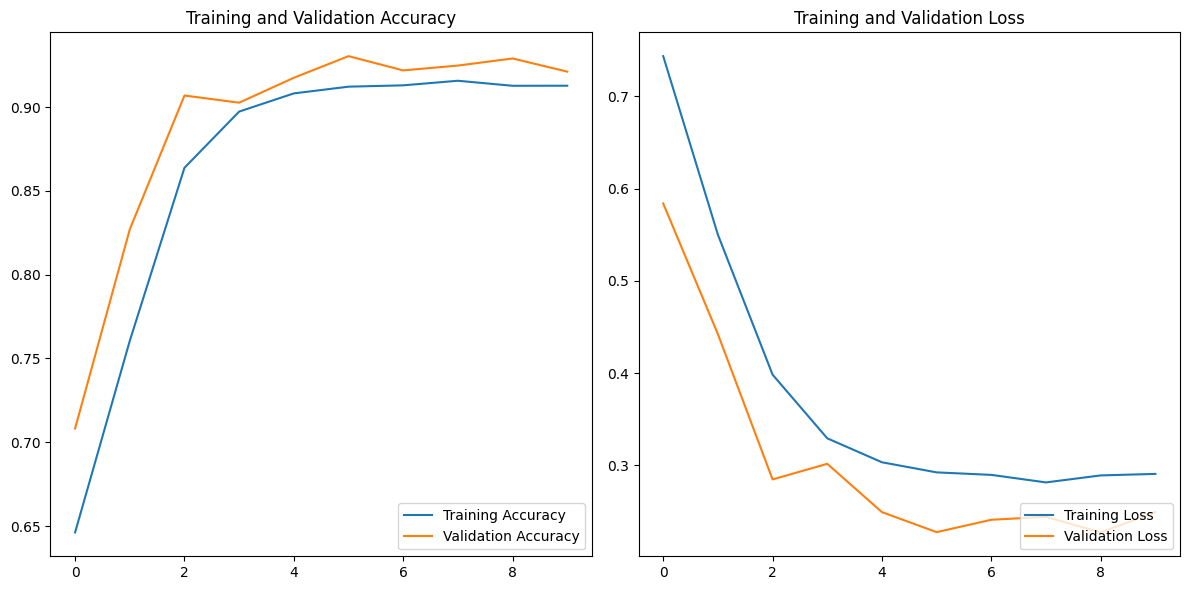

In [70]:
WINDOW_LENGTH = 20
    
X_train, X_test, y_train, y_test = prepare_data(df_motionSense, WINDOW_LENGTH)


model_3 = Sequential([
    SimpleRNN(128, activation='tanh', input_shape=(WINDOW_LENGTH, NUM_FEATURES)),
    Dropout(0.5),         
    Flatten(),
    Dense(64, activation='relu'),
    BatchNormalization(),  
    Dropout(0.5),          
    Dense(NUM_CLASSES, activation='softmax')
])

model_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_3.summary()

model_3.save('../models/model_3/model_3_h7.keras')

start_time = time.time()

history_7 = model_3.fit(X_train, y_train, epochs=EPOCHS, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping, reduce_lr])

end_time = time.time()
execution_time = end_time - start_time
print(f"Tempo de execução: {execution_time} segundos")

history_path = '../models/model_3/history_7.pkl'
with open(history_path, 'wb') as file:
    pickle.dump(history_7.history, file)


loss, accuracy = model_3.evaluate(X_test, y_test)
print(f'Test loss: {loss}, Test accuracy: {accuracy}')

plot_training_results(history_7)

---

### **Janela Temporal = 30**

Model: "sequential_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_37 (SimpleRNN)       │ (None, 128)            │        18,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_30 (Flatten)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,755 (104.51 KB)

 Trainable params: 26,627 (104.01 KB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 44s 4ms/step - accuracy: 0.7346 - loss: 0.6373 - val_accuracy: 0.6704 - val_loss: 0.6712 - learning_rate: 0.0010
Epoch 2/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - accuracy: 0.6701 - loss: 0.6742 - val_accuracy: 0.4853 - val_loss: 1.0292 - learning_rate: 0.0010
Epoch 3/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - accuracy: 0.5340 - loss: 0.9162 - val_accuracy: 0.5023 - val_loss: 0.9995 - learning_rate: 0.0010
Epoch 4/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - accuracy: 0.5564 - loss: 0.8476 - val_accuracy: 0.6615 - val_loss: 0.6129 - learning_rate: 0.0010
Epoch 5/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - accuracy: 0.6139 - loss: 0.7541 - val_accuracy: 0.6724 - val_loss: 0.6015 - learning_rate: 0.0010
Epoch 6/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - accuracy: 0.6821 - loss: 0.6414 - val_accuracy: 0.7120 - val_loss: 0.5611 - learning_rate: 0.0010
Epoch 7/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step -

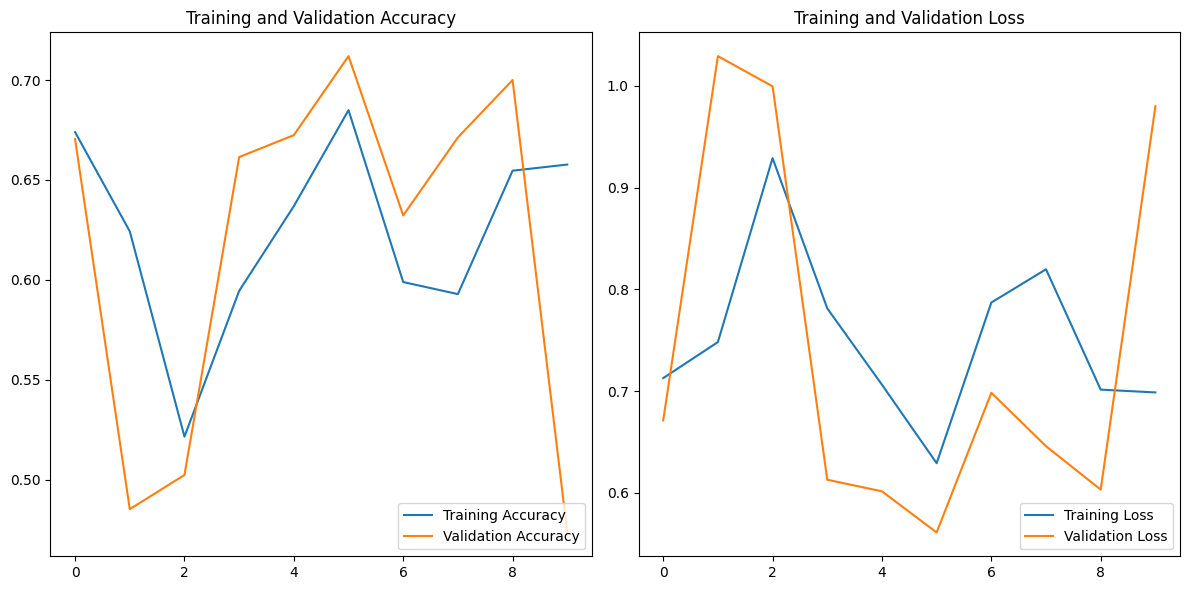

In [89]:
WINDOW_LENGTH = 30
    
X_train, X_test, y_train, y_test = prepare_data(df_motionSense, WINDOW_LENGTH)


model_3 = Sequential([
    SimpleRNN(128, activation='tanh', input_shape=(WINDOW_LENGTH, NUM_FEATURES)),
    Dropout(0.5),          
    Flatten(),
    Dense(64, activation='relu'),
    BatchNormalization(),  
    Dropout(0.5),          
    Dense(NUM_CLASSES, activation='softmax')
])

model_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_3.summary()

model_3.save('../models/model_3/model_3_h8.keras')

start_time = time.time()

history_8 = model_3.fit(X_train, y_train, epochs=EPOCHS, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping, reduce_lr])

end_time = time.time()
execution_time = end_time - start_time
print(f"Tempo de execução: {execution_time} segundos")

history_path = '../models/model_3/history_8.pkl'
with open(history_path, 'wb') as file:
    pickle.dump(history_8.history, file)


loss, accuracy = model_3.evaluate(X_test, y_test)
print(f'Test loss: {loss}, Test accuracy: {accuracy}')

plot_training_results(history_8)

---

### **Janela Temporal = 50**

Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_36 (SimpleRNN)       │ (None, 128)            │        18,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_29 (Flatten)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,755 (104.51 KB)

 Trainable params: 26,627 (104.01 KB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 63s 6ms/step - accuracy: 0.6014 - loss: 0.8614 - val_accuracy: 0.4274 - val_loss: 1.0696 - learning_rate: 0.0010
Epoch 2/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 53s 5ms/step - accuracy: 0.5220 - loss: 0.9306 - val_accuracy: 0.5889 - val_loss: 0.9867 - learning_rate: 0.0010
Epoch 3/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 53s 5ms/step - accuracy: 0.5648 - loss: 0.8590 - val_accuracy: 0.4749 - val_loss: 1.0094 - learning_rate: 0.0010
Epoch 4/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 52s 5ms/step - accuracy: 0.5311 - loss: 0.9080 - val_accuracy: 0.6239 - val_loss: 0.7113 - learning_rate: 0.0010
Epoch 5/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 57s 5ms/step - accuracy: 0.5999 - loss: 0.7860 - val_accuracy: 0.5033 - val_loss: 0.9591 - learning_rate: 0.0010
Epoch 6/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 58s 5ms/step - accuracy: 0.4757 - loss: 1.0065 - val_accuracy: 0.6116 - val_loss: 0.7982 - learning_rate: 0.0010
Epoch 7/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 57s 5ms/step -

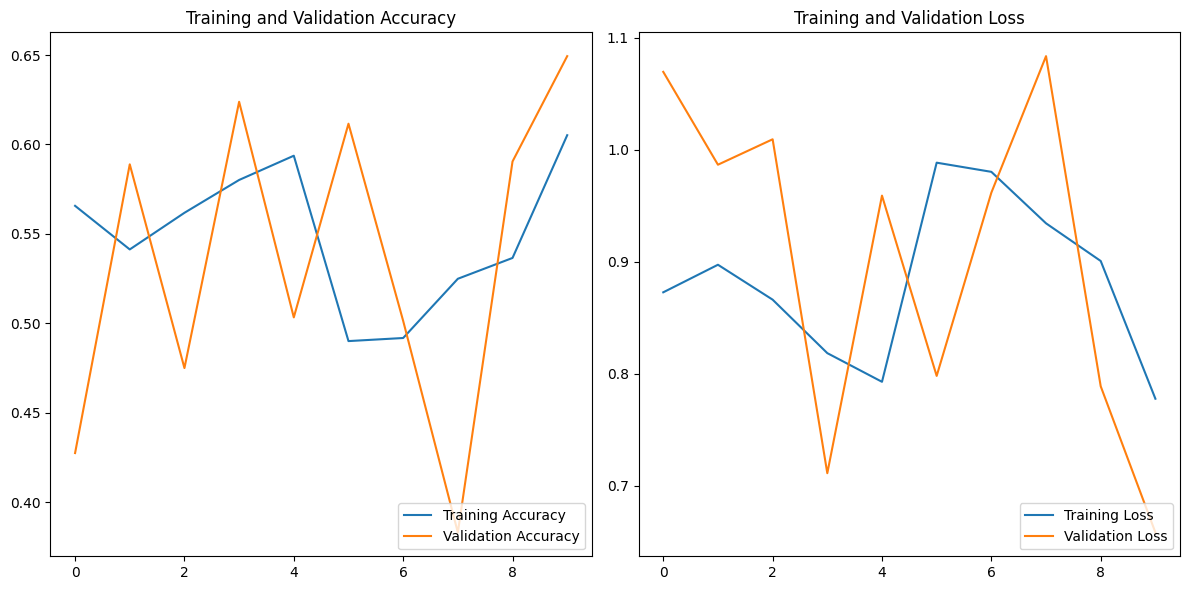

In [88]:
WINDOW_LENGTH = 50
    
X_train, X_test, y_train, y_test = prepare_data(df_motionSense, WINDOW_LENGTH)


model_3 = Sequential([
    SimpleRNN(128, activation='tanh', input_shape=(WINDOW_LENGTH, NUM_FEATURES)),
    Dropout(0.5),          
    Flatten(),
    Dense(64, activation='relu'),
    BatchNormalization(),  
    Dropout(0.5),          
    Dense(NUM_CLASSES, activation='softmax')
])

model_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_3.summary()

model_3.save('../models/model_3/model_3_h9.keras')

start_time = time.time()

history_9 = model_3.fit(X_train, y_train, epochs=EPOCHS, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping, reduce_lr])

end_time = time.time()
execution_time = end_time - start_time
print(f"Tempo de execução: {execution_time} segundos")

history_path = '../models/model_3/history_9.pkl'
with open(history_path, 'wb') as file:
    pickle.dump(history_9.history, file)


loss, accuracy = model_3.evaluate(X_test, y_test)
print(f'Test loss: {loss}, Test accuracy: {accuracy}')

plot_training_results(history_9)

---

---

## **Comparação dos Resultados Obtidos**

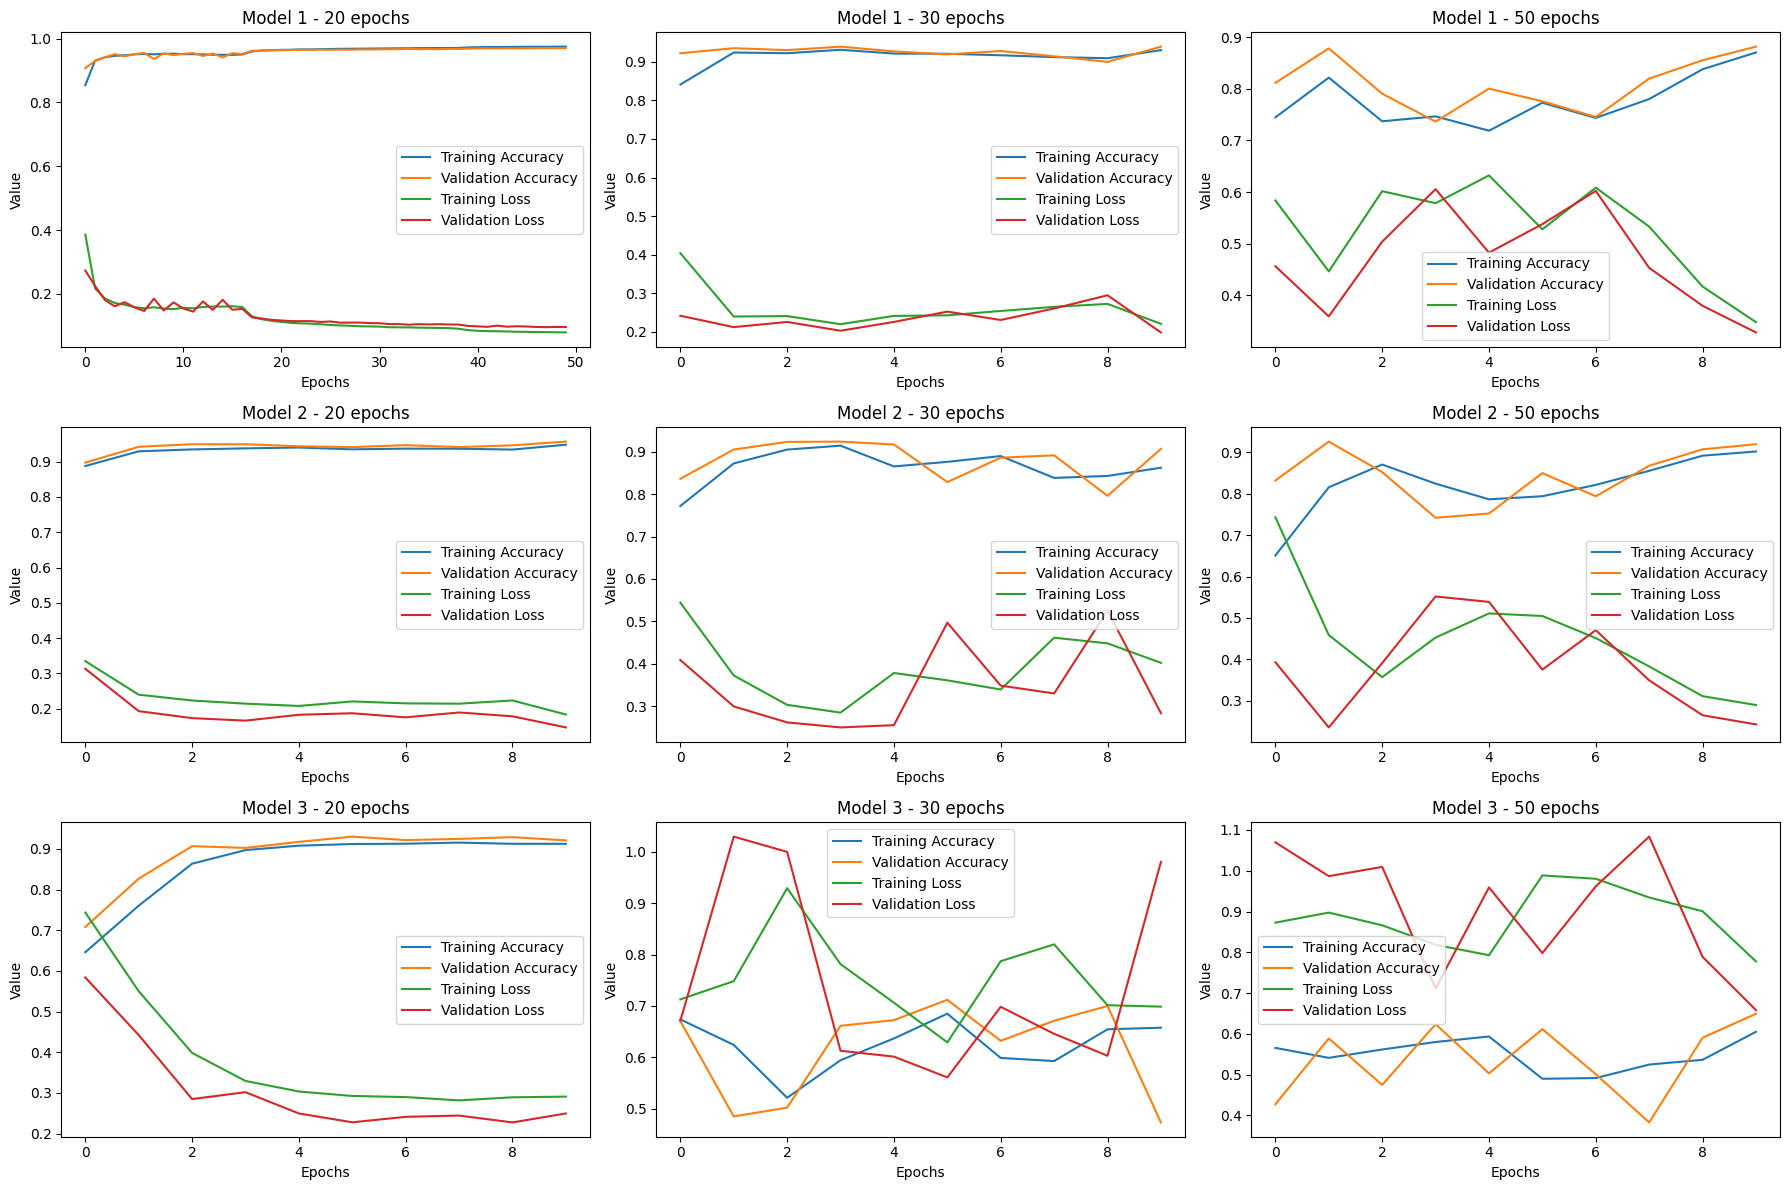

In [91]:
# Função para carregar os históricos
def load_history(path):
    with open(path, 'rb') as file:
        return pickle.load(file)

# Carregar os históricos salvos
history_1_path = '../models/model_1/history_1.pkl'
history_2_path = '../models/model_1/history_2.pkl'
history_3_path = '../models/model_1/history_3.pkl'
history_4_path = '../models/model_2/history_4.pkl'
history_5_path = '../models/model_2/history_5.pkl'
history_6_path = '../models/model_2/history_6.pkl'
history_7_path = '../models/model_3/history_7.pkl'
history_8_path = '../models/model_3/history_8.pkl'
history_9_path = '../models/model_3/history_9.pkl'

# Carregar os históricos
history_1 = load_history(history_1_path)
history_2 = load_history(history_2_path)
history_3 = load_history(history_3_path)
history_4 = load_history(history_4_path)
history_5 = load_history(history_5_path)
history_6 = load_history(history_6_path)
history_7 = load_history(history_7_path)
history_8 = load_history(history_8_path)
history_9 = load_history(history_9_path)

# Lista de históricos para apresentar os gráficos
histories = [history_1, history_2, history_3, history_4, history_5, history_6, history_7, history_8, history_9]
labels = ['Model 1 - 20 epochs', 'Model 1 - 30 epochs', 'Model 1 - 50 epochs', 'Model 2 - 20 epochs', 'Model 2 - 30 epochs', 'Model 2 - 50 epochs', 'Model 3 - 20 epochs', 'Model 3 - 30 epochs', 'Model 3 - 50 epochs']

# Função para apresentar os gráficos dos múltiplos históricos
def plot_multiple_histories(histories, labels):
    plt.figure(figsize=(18, 12))

    for i, (history, label) in enumerate(zip(histories, labels)):
        plt.subplot(3, 3, i+1)

        plt.plot(history['accuracy'], label='Training Accuracy')
        plt.plot(history['val_accuracy'], label='Validation Accuracy')
        
        plt.plot(history['loss'], label='Training Loss')
        plt.plot(history['val_loss'], label='Validation Loss')
        
        plt.title(label)
        plt.xlabel('Epochs')
        plt.ylabel('Value')
        plt.legend()

    plt.tight_layout()
    plt.show()

plot_multiple_histories(histories, labels)
